In [1]:


import numpy as np 
import pandas as pd 



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -U -q kaggle

In [4]:
!pwd

/content


In [5]:

!mkdir -p ~/.kaggle

In [6]:
!cp /content/sample_data/kaggle.json ~/.kaggle
!kaggle datasets list


ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-14 18:29:44           3445  
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               577KB  2021-01-15 07:58:28           2112  
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21           1845  
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14            492  
google/android-smartphones-high-accuracy-datasets   

In [7]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls

creditcardfraud.zip  drive  sample_data


In [9]:
import tensorflow as tf

In [10]:
#Imports
import warnings
warnings.filterwarnings(action='ignore')

import time
import copy
import random

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile




Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
credit_zip = ZipFile('/content/creditcardfraud.zip')

raw_df = pd.read_csv(credit_zip.open('creditcard.csv'))
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
raw_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


From the result describe function above - we observe that Time distribution is probably skewred towards right and Amount has lot outliers. Lets now further investigate these observation.

In [14]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



**Highly imbalanced Datase, as we can see less than 1% is positive**

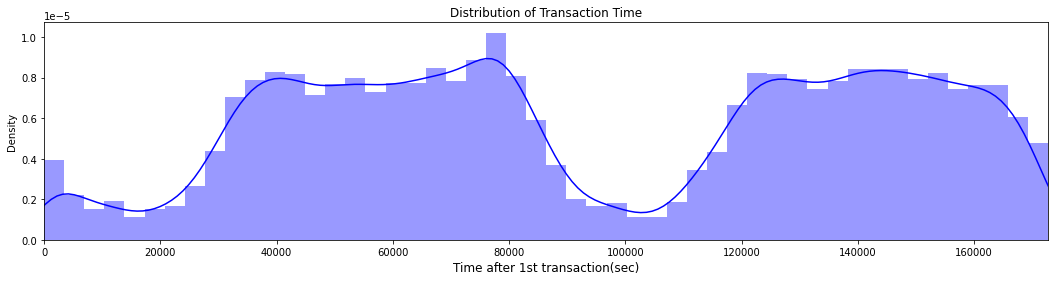

In [15]:
fig, ax = plt.subplots(figsize=(18,4))

amount_val = raw_df['Amount'].values
time_val = raw_df['Time'].values

sns.distplot(time_val, ax=ax, color='b')
ax.set_title('Distribution of Transaction Time', fontsize=12)
ax.set_xlim([min(time_val), max(time_val)])
ax.set_xlabel('Time after 1st transaction(sec)', fontsize=12);


plt.show()

**This time distribution does not give much information so let's convert the time into hours of the day**

In [16]:
cleaned_df = raw_df.copy()

cleaned_df['Time'] = ((cleaned_df['Time']/3600)%24).sort_values(ascending=False)

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log_amount'] = np.log(cleaned_df['Amount']+eps)

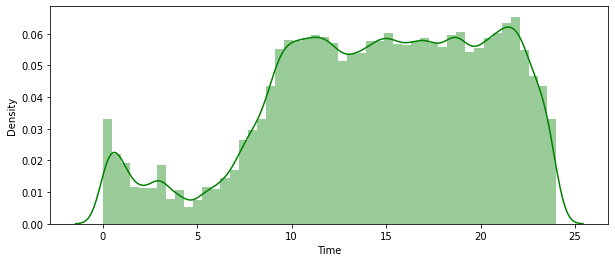

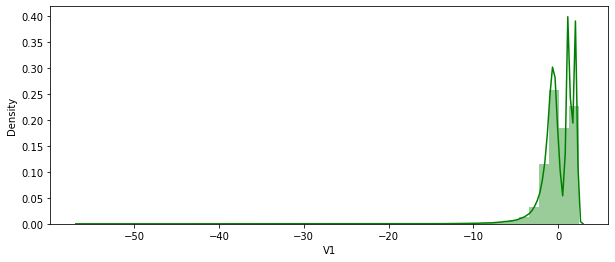

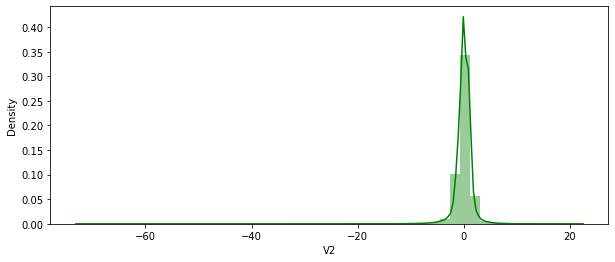

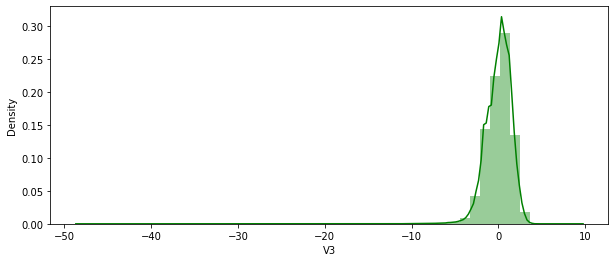

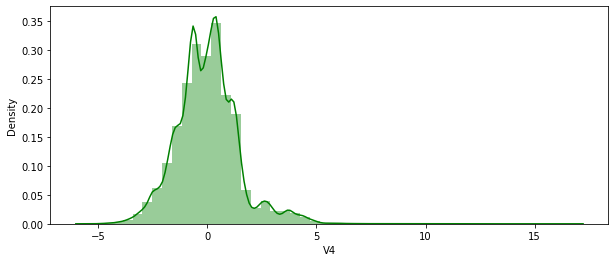

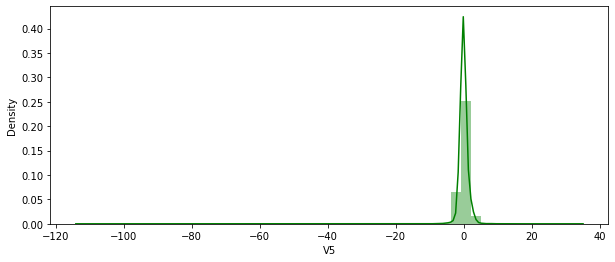

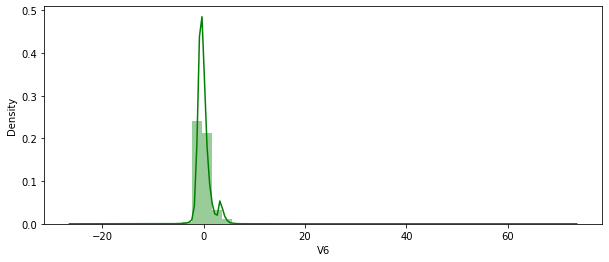

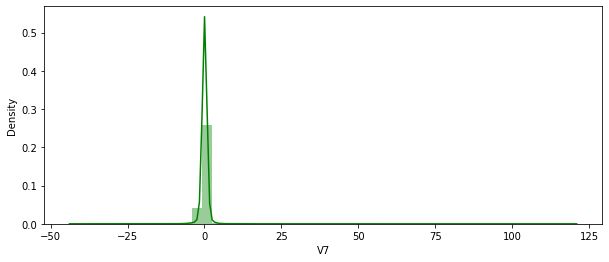

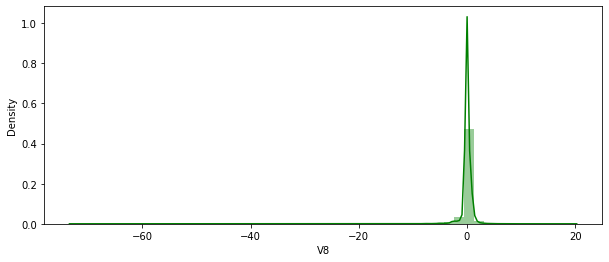

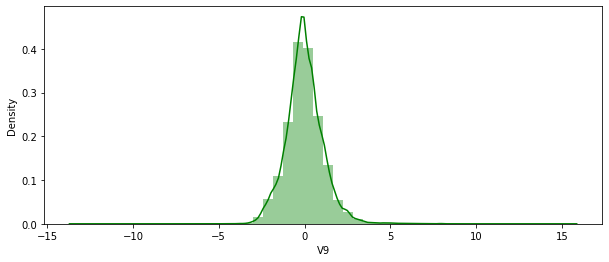

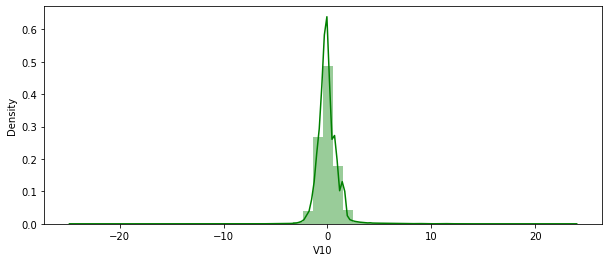

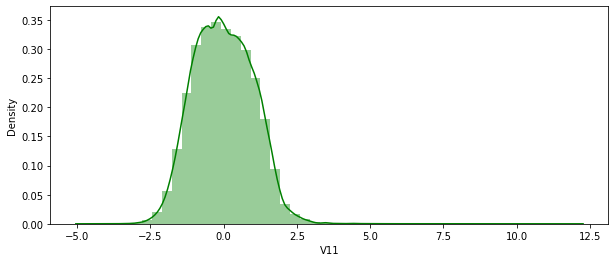

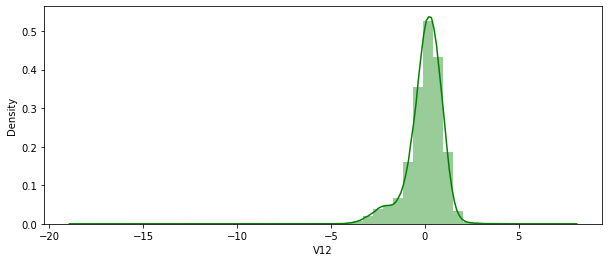

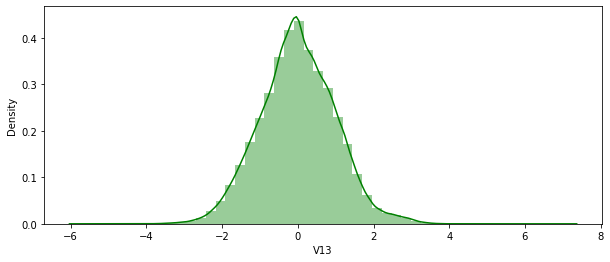

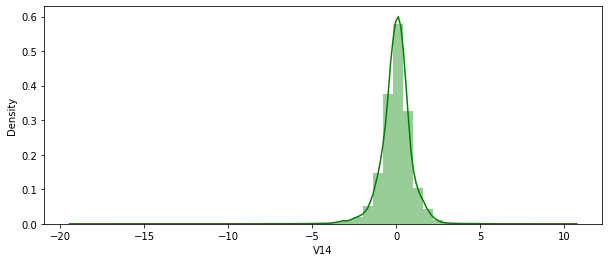

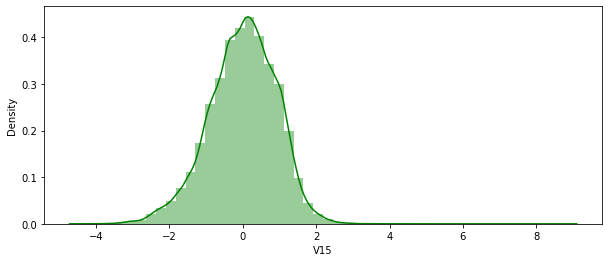

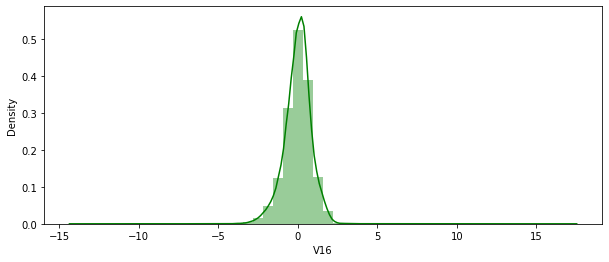

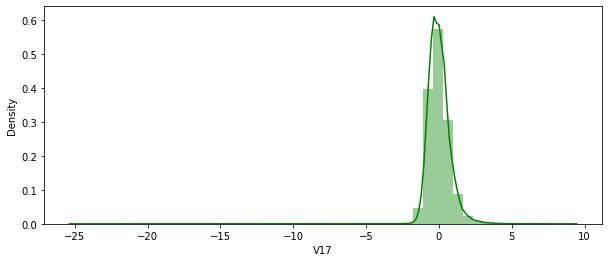

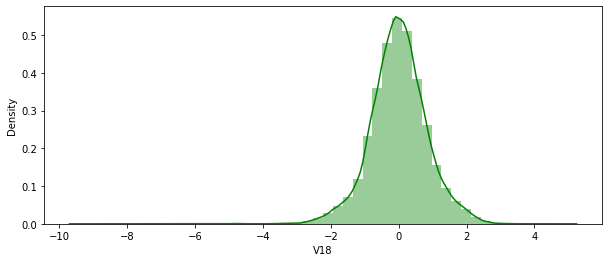

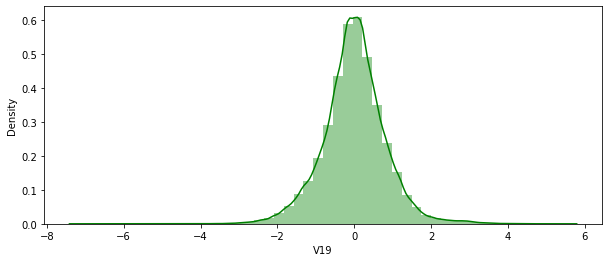

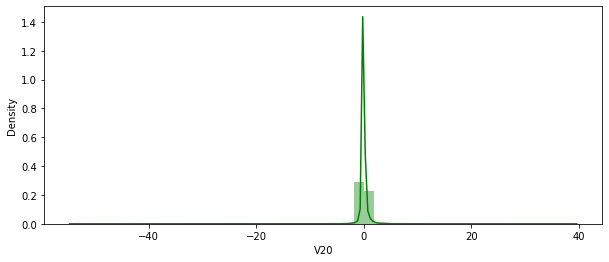

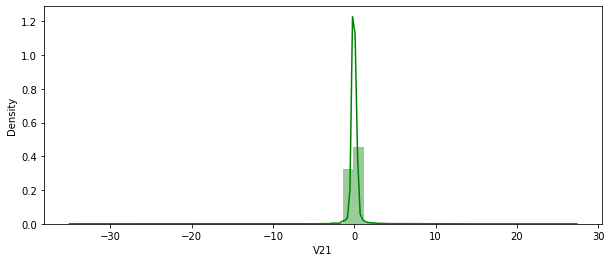

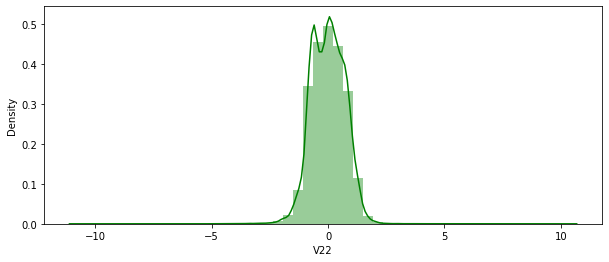

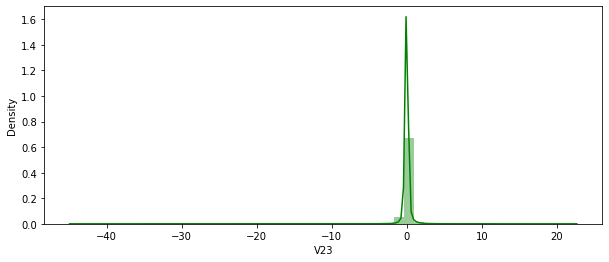

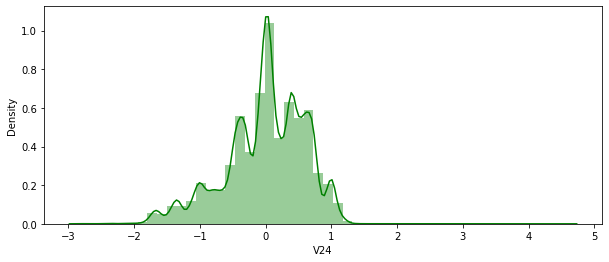

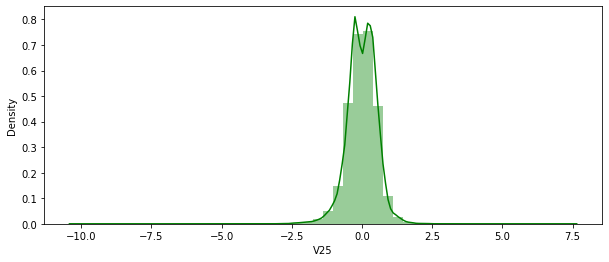

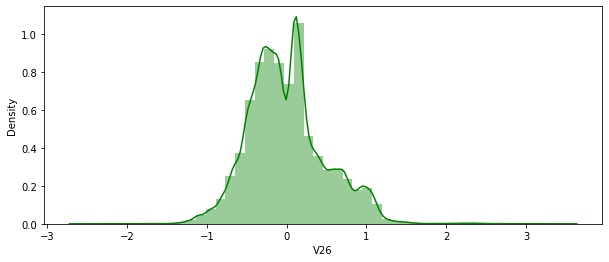

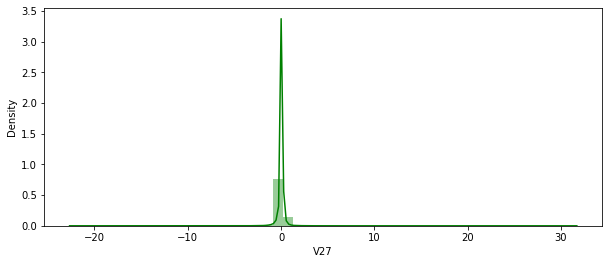

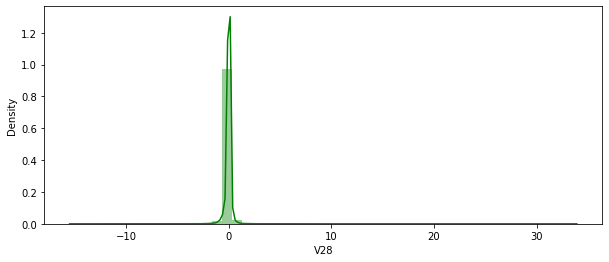

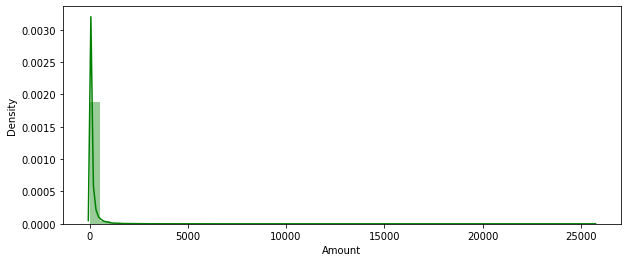

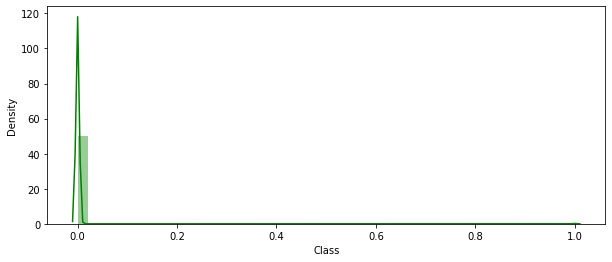

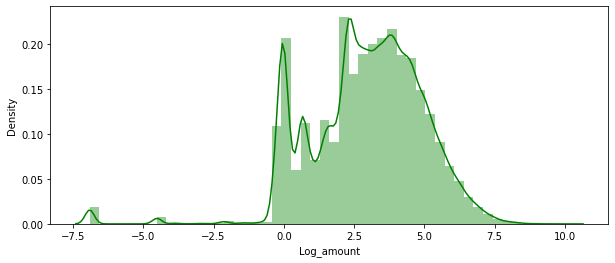

In [17]:
def variable_distribution_analysis(dataset):

        
    numerical_features=[feature for feature in dataset.columns if dataset[feature].dtype!='O']

    for feature in numerical_features:
        plt.figure(figsize=(10,4))
        try:
            sns.distplot(dataset[feature],color='g')
            plt.show()
        except:
            continue


    #sns.pairplot(dataset,kind="reg")
    #plt.show()
    
variable_distribution_analysis(cleaned_df)

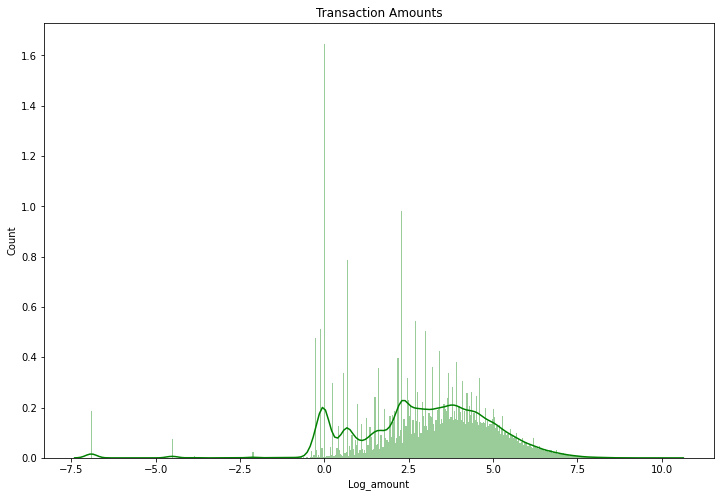

In [18]:
plt.figure(figsize=(12,8))
sns.distplot(cleaned_df['Log_amount'],bins=500,color='g')
plt.ylabel('Count')
plt.title('Transaction Amounts');

Observation : 
1. All the PCA variables (V1-V28) are centred at 0,and seem normalized.
2. Amount distribution is also on the lower range, mean = 88 and there are outliers with one transcation of atleast 25,000. 
3. As suspected the numbers of transactions are higher between 10AM-11PM, compared to 1AM to 9AM.
4. The target variable class is highly imbalanced

Lets explore relationship between Amount and time of the hour

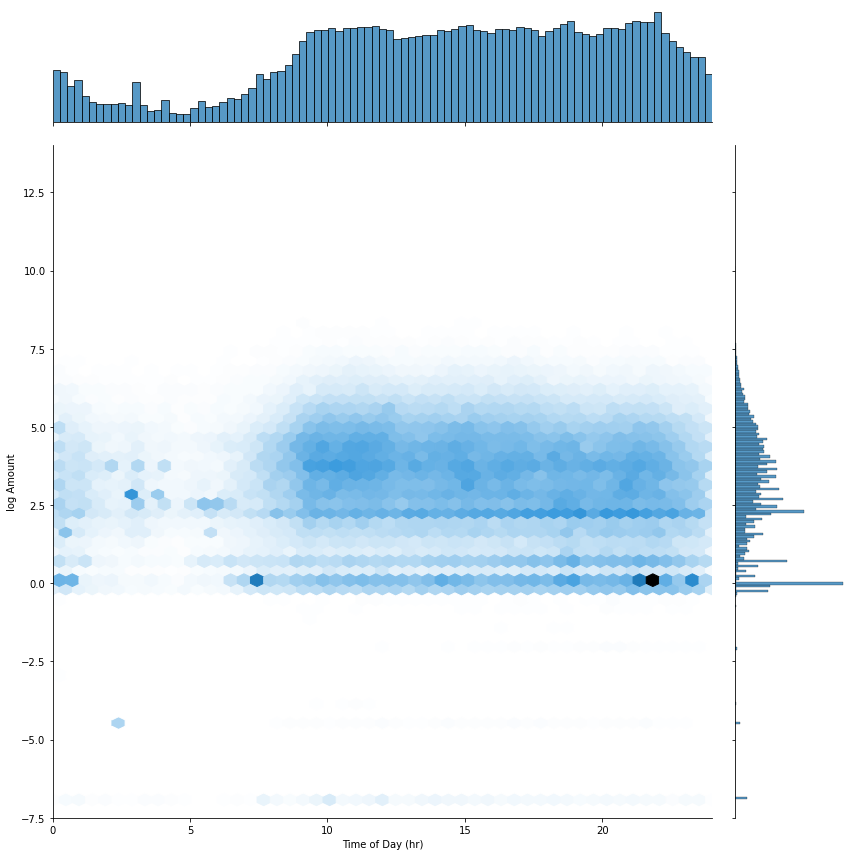

In [19]:
sns.jointplot(cleaned_df['Time'], cleaned_df['Log_amount'], kind='hex', height=12, xlim=(0,24), ylim=(-7.5,14)).set_axis_labels('Time of Day (hr)','log Amount')


**The higher amount transaction are happening in between 9AM to Noon. And then we have surge in number of low amount transaction at around 10 - 11 PM.**

### Outliers Check

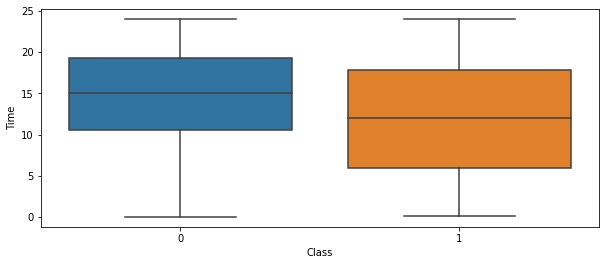

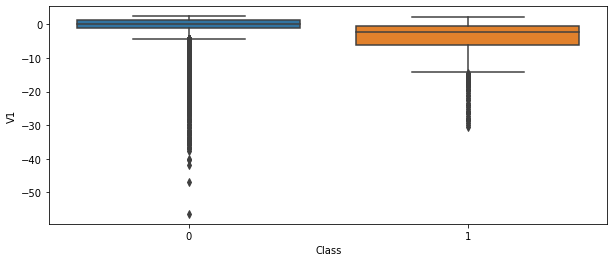

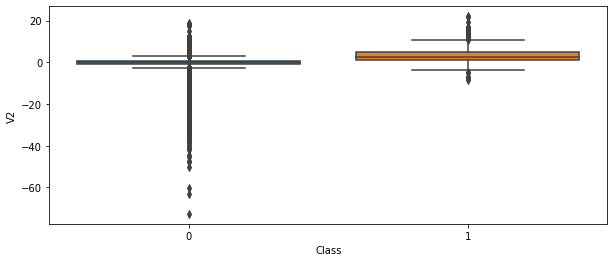

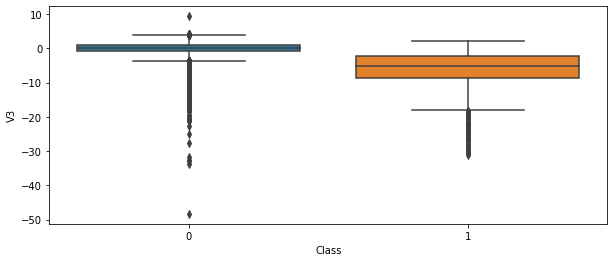

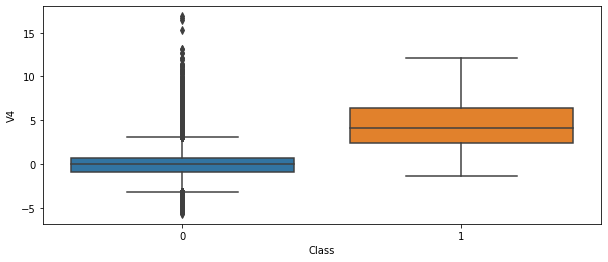

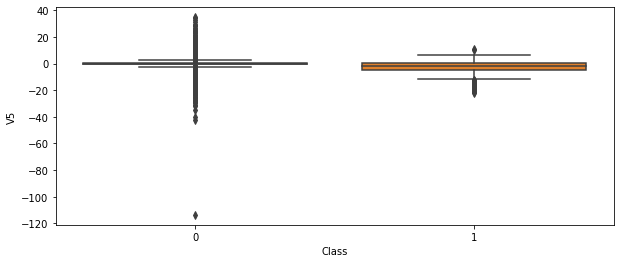

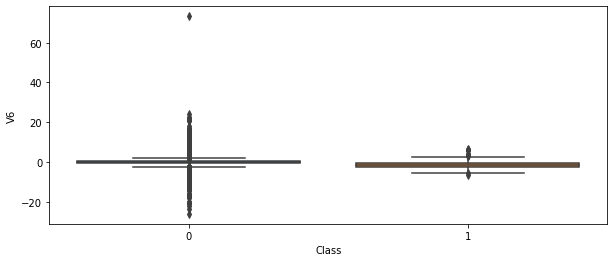

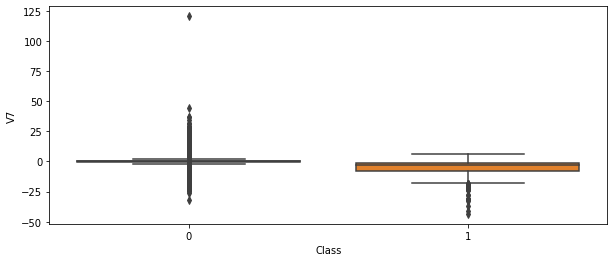

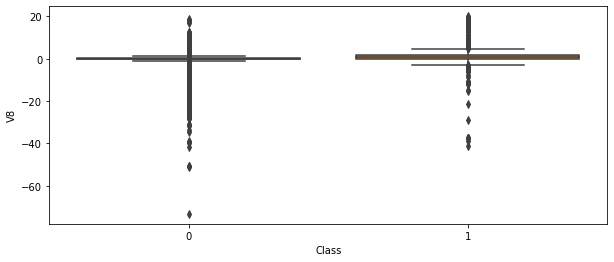

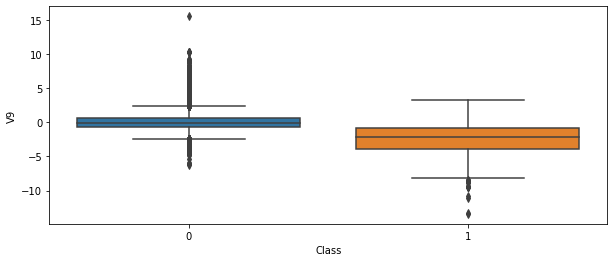

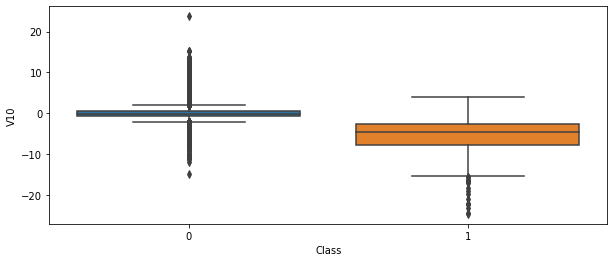

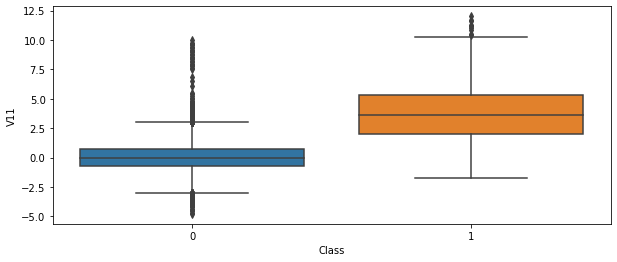

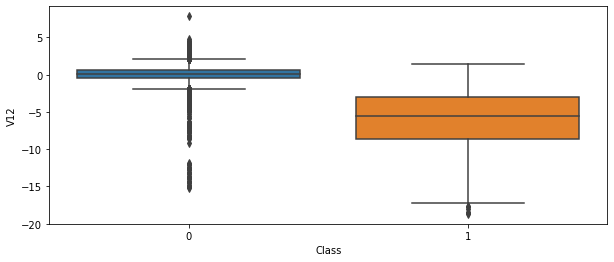

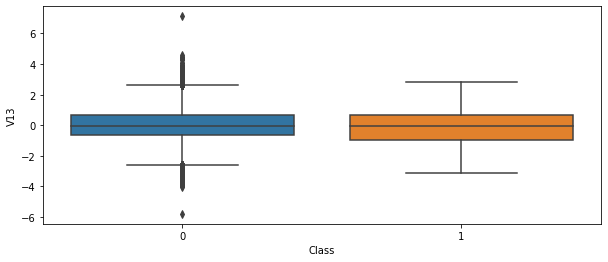

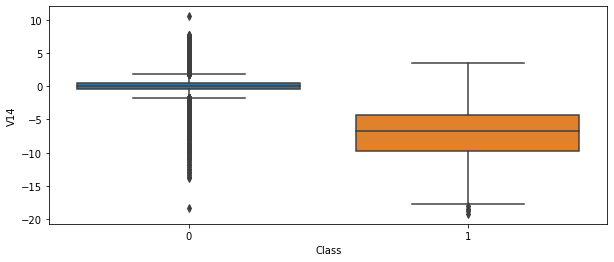

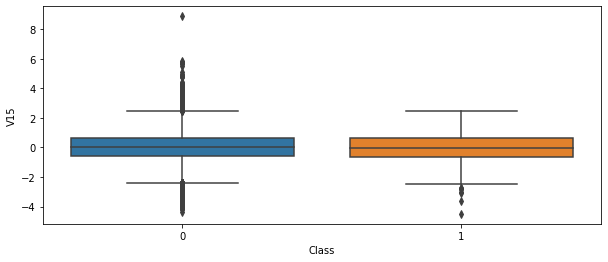

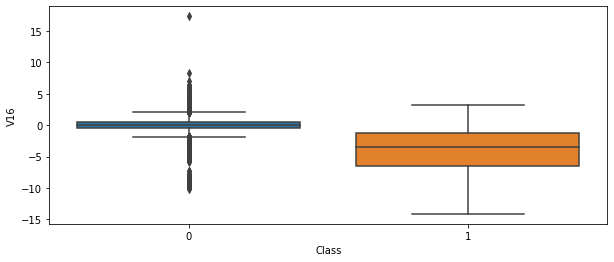

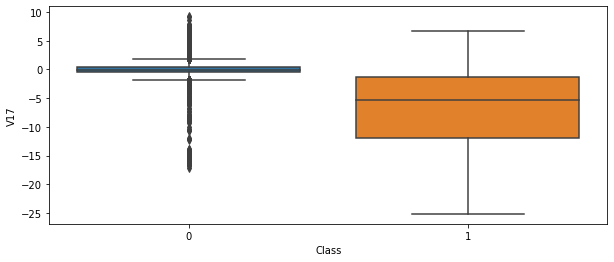

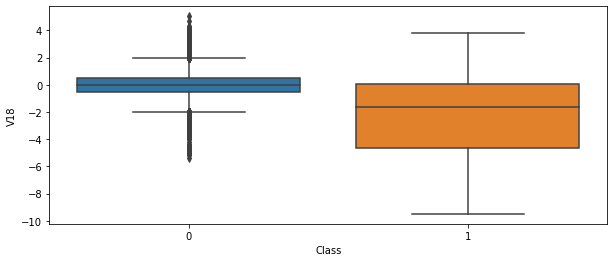

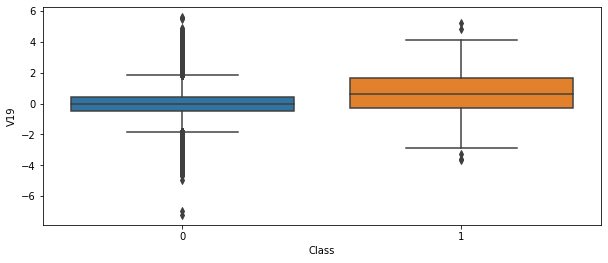

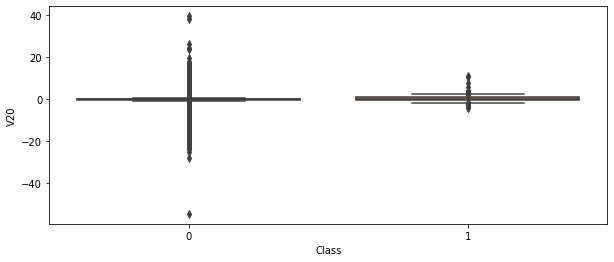

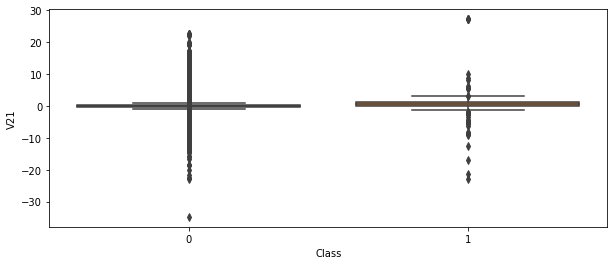

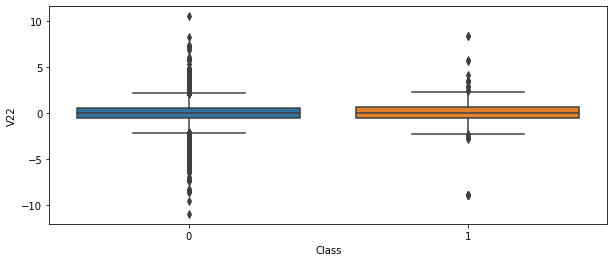

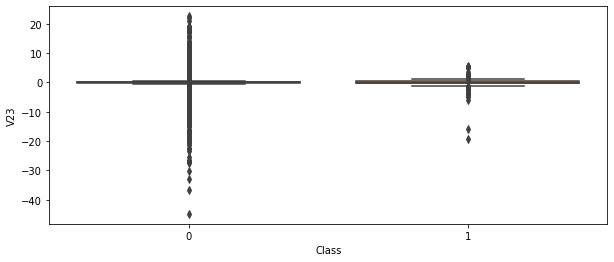

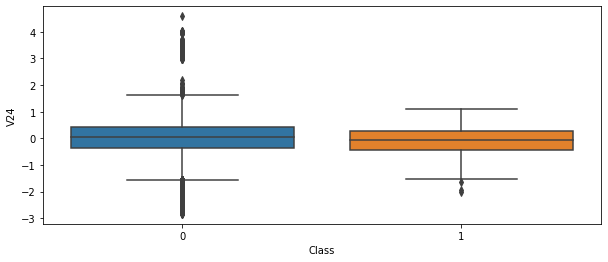

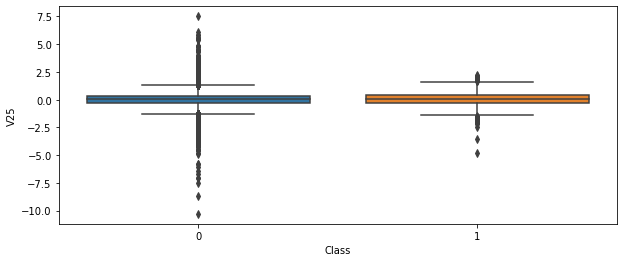

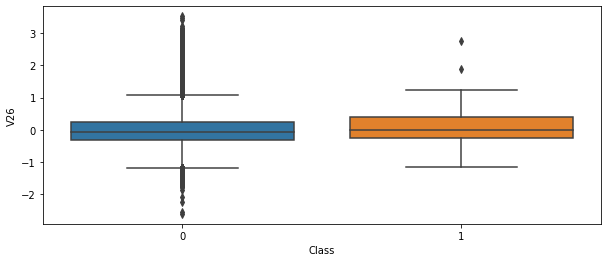

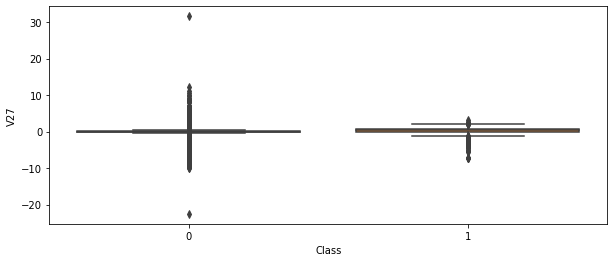

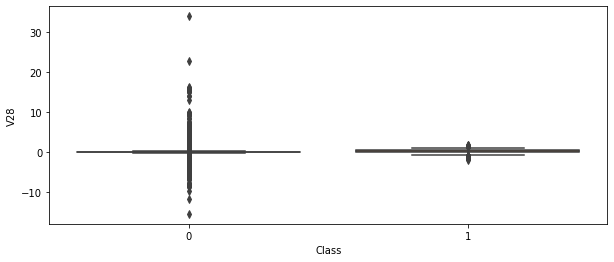

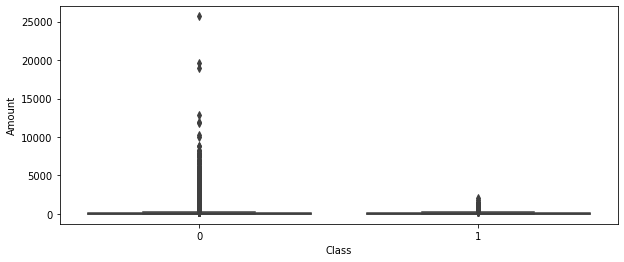

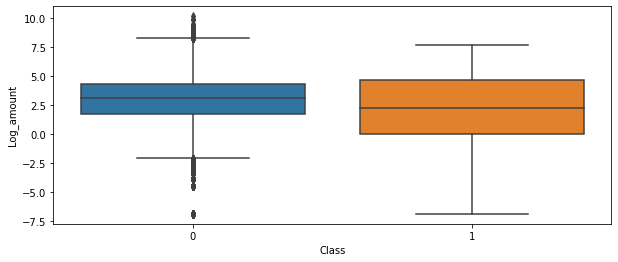

In [20]:
for col in list(cleaned_df.columns):
    if col!='Class':
        plt.figure(figsize=(10,4))
        sns.boxplot(data=cleaned_df,x='Class',y=col)
        plt.show()

Long tail of outliers can be observed for PCA variables. But both classes are behaving differently incase of the outliers 

In [21]:
pca_vars = ['V%i' % k for k in range(1,29)]

In [22]:
cleaned_df[pca_vars].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01


Mean of all the PCA variables are approx 0 and standard deviation is between 0 and 2 with mostly a unit value. Let's check the tailedness by ploting Kurtosis distribution

Original dataset is Imbalanced! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud

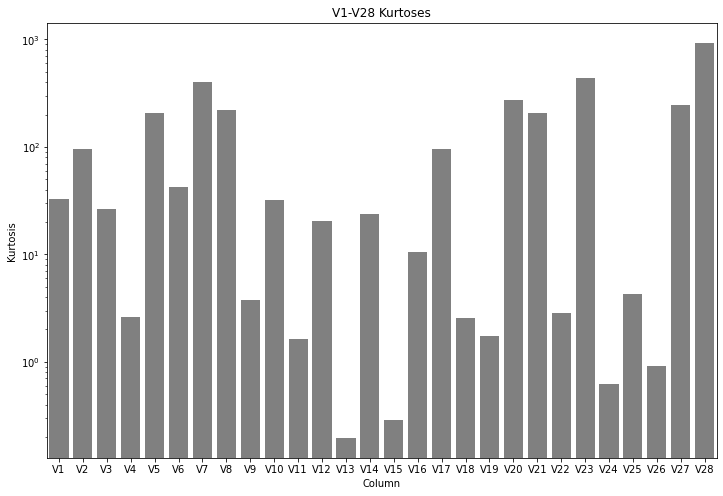

In [23]:
plt.figure(figsize=(12,8))
plt.yscale('log')
sns.barplot(x=pca_vars, y=cleaned_df[pca_vars].kurtosis(), color='gray')
plt.xlabel('Column')
plt.ylabel('Kurtosis')
plt.title('V1-V28 Kurtoses');

As suspected most of the PCA variables have high Kurtosis (>3) values which is also indicated in the box chart above.

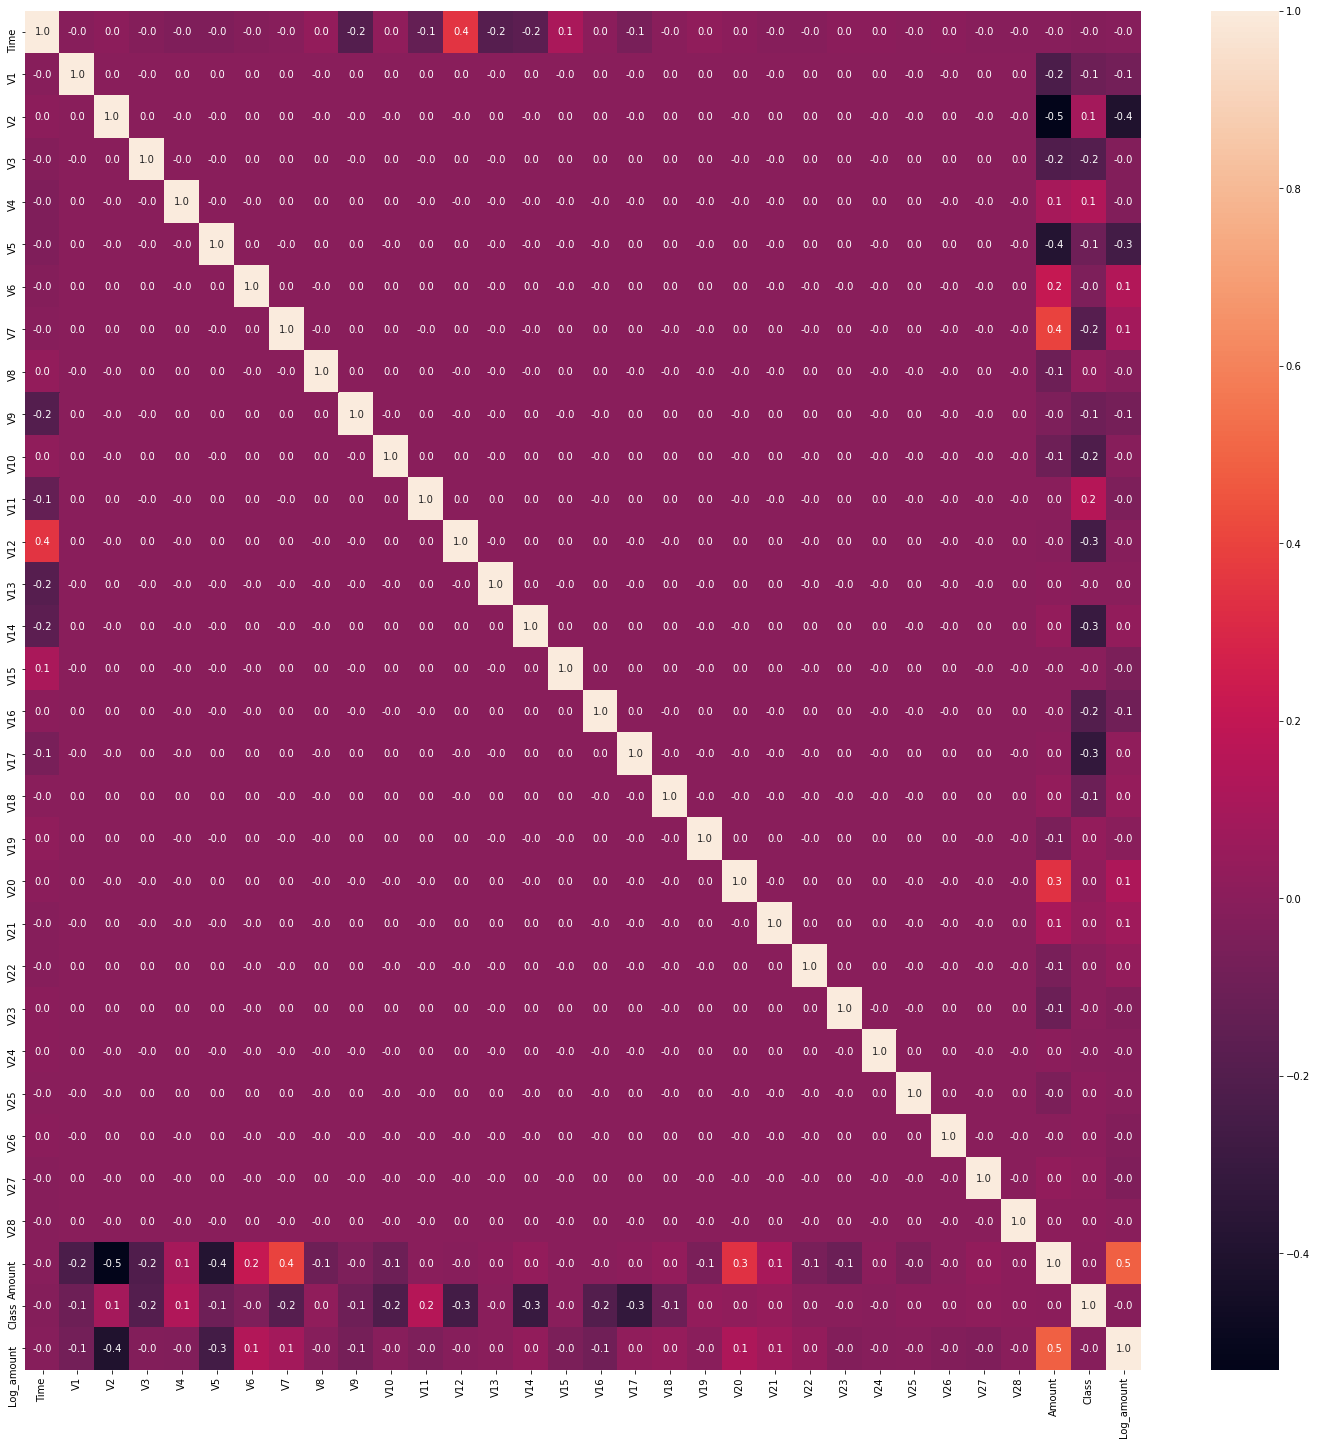

In [24]:
cleaned_df_corr = cleaned_df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(data=cleaned_df_corr, annot=True,fmt='.1f');

No feature with high correlation (>7 and <-7) detected.

In [25]:
cleaned_df.groupby(['Class'])['Amount'].agg({'min','max','mean','median','std','count'}).reset_index()

,Class,median,mean,count,max,min,std
0,0,22.00,88.291022,284315,25691.16,0.0,250.105092
1,1,9.25,122.211321,492,2125.87,0.0,256.683288


# Machine learning Algorithm

### Balancing the Imbalanced Data

In [26]:
class GAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=30, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.placeholder(tf.float32, [None, self.X_node_], name=X_name)
        self.prior_z_ = tf.placeholder(tf.float32, [None, self.z_dim_], name=z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
#         g_out = tf.nn.sigmoid(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])

        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.log(self.y_data_) + tf.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.log(self.gen_y_))
                # Alternate generator loss function optimisation: - tf.reduce_mean(tf.log(self.gen_y_))
                
        else:
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        # optimiser = tf.train.AdadeltaOptimizer(learning_rate=1.0)
        optimiser = tf.train.AdamOptimizer(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)     
        self.d_trainer_ = tf.train.GradientDescentOptimizer(learning_rate=train_step).minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.train.AdamOptimizer(learning_rate=train_step).minimize(self.g_loss_, var_list=self.gen_params_)

In [27]:
class WassersteinGAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=29, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.placeholder(tf.float32, [None, self.X_node_], name=X_name)
        self.prior_z_ = tf.placeholder(tf.float32, [None, self.z_dim_], name=z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.clip_dis_, self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        # Activation changed from sigmoid to tanh
        
        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]
        
        # Clipping of discriminator
        self.clip_dis_ = [param.assign(tf.clip_by_value(param, -0.05, 0.05)) for param in self.dis_params_]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.log(self.y_data_) + tf.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.log(self.gen_y_))
                # Alternate generator loss function optimisation to avoid vanishing gradients: - tf.reduce_mean(tf.log(self.gen_y_))
        
        else:     
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        optimiser = tf.train.RMSPropOptimizer(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)
        self.d_trainer_ = tf.train.GradientDescentOptimizer(learning_rate=train_step).minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.train.AdamOptimizer(learning_rate=train_step).minimize(self.g_loss_, var_list=self.gen_params_)

In [28]:
#Functions defined
def uniform_draw_feat_class(data_df, target_name, draw_size):
    """ Sample out 1 particular class out of the full data uniformly in a predefined sample size,
    segregate pandas dataframe into their respective target classes. """
    
    # Break down full dataset into their respective classes
    target_class_dfs = {}
    n_classes = data_df[target_name].unique()
    
    for unique_class in n_classes:
        # Store each segregated class dataframes as dictionary
        class_i_df = data_df[data_df[target_name] == unique_class]
        class_i_df = (class_i_df.reset_index()).drop(columns=['index'])
        target_class_dfs[unique_class] = class_i_df
        
    # Obtain uniform samples of size 'draw_size' and store as dictionary
    uniform_class_sample_draws = {}
    
    # Pandas df. sampling default None equivalently uniform draws
    for unique_class in n_classes:
        unif_samples = target_class_dfs[unique_class].sample(n=draw_size, replace=True)
        sample_df = pd.DataFrame(unif_samples, columns=data_df.columns)    
        uniform_class_sample_draws[unique_class] = unif_samples
    
    # Returns dictionary of pandas dataframes, split into respective classes
    return uniform_class_sample_draws

def xavier_init(size, label, data_type):
    """ For usage in tensorflow neural nets weights initialisation per layer.
    Helps resolve issue of overfitting to data. """
    
    tf.set_random_seed(42)
    in_dim = size[0]; out_dim = size[1]
    xavier_stddev = 1. / tf.sqrt((in_dim + out_dim) / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, name=label, dtype=data_type)

def steady_epoch(loss_lst, num_epochs_ran, sd_fluc_pct=0.15, scan_frame=225, stab_fn=min):   
    """ 
    FOR THE PURPOSE OF FINDING A FRAME OF EPOCHS WHERE THE LOSSES HAS STABILISED WITHIN SPECIFIED PERCENTAGE OF 
    1SD OF LOSSES FOR ALL EPOCHS EXECUTED
    
    DEFAULT FRAME OF EPOCHS WHERE LOSS IS CONSIDERED STEADY IS 225, FLUCTUATING WITHIN +/- 15% OF 1 S.D. OF THE LOSSES
    
    [EXAMPLE - 5% OF S.D., 5% OF TOTAL EPOCHS RAN]
    Obtain minimum of losses and its corresponding 1 s.d. of loss of the given array of losses
    Do for a list of losses
        For some 5% out of all epochs ran
            if that particular 5% of epochs have losses each within +/-5% of the minimum loss,
                Epoch frame chosen as steady epoch-period
                Else return 'no steady epoch-periods found'; break
        Return frame of epochs found 
    """
    # Obtain minimum and s.d. value of the losses for all epochs
    loss_1sd = np.std(loss_lst)
    stab_fn_loss = stab_fn(loss_lst)

    epoch_frame_start = 0
    epoch_frame_end = epoch_frame_start + scan_frame
    
    # Return nothing in the event no frame of losses are found to have steady losses
    steady_frame=None
    
    # For loop termination
    exit_loop = True
    while exit_loop:

        # Reset counter when one of the epoch is not within +/-'sd_fluc_pct'% of minimum losses
        counter_5pct = 0

        for epoch in range(epoch_frame_start, epoch_frame_end, 1):
            if (loss_lst[epoch] > stab_fn_loss and loss_lst[epoch] <= (stab_fn_loss + sd_fluc_pct*loss_1sd)) \
            or (loss_lst[epoch] < stab_fn_loss and loss_lst[epoch] >= (stab_fn_loss - sd_fluc_pct*loss_1sd)):
                
                # Increase counter progressively until all (225) epochs in 'scan_frame' are within specified tolerance
                counter_5pct += 1

                # When (225) epochs are within +/-'sd_fluc_pct'% of minimal loss, flag the (225th) final epoch
                if counter_5pct == scan_frame:
                    print('Steady epoch frame found at epoch {} as final'.format(epoch_frame_end))
                    
                    # Return numpy array of epoch numbers within (225) specified range
                    steady_frame = np.linspace(start=(epoch_frame_end-scan_frame+1), stop=epoch_frame_end, num=scan_frame)
                    exit_loop = False
                    break           
            else:
                break

        # When a frame of 225 epochs within +/-'sd_fluc_pct'% of minimum losses is not found,
            # shift to next frame by 1 epoch
        epoch_frame_start += 1
        epoch_frame_end += 1

        if epoch_frame_end > num_epochs_ran:
            print('No steady epoch frame found!')
            break

    return steady_frame

In [29]:
cleaned_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Log_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913


In [30]:
cleaned_df=cleaned_df.drop(columns=['Amount','Time'], axis=1)

In [31]:
### Load credit card data and preprocessing ###

x = cleaned_df.drop(columns='Class', axis=1)
y = cleaned_df['Class'].to_numpy()

# Train-test split data: 75/25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:

# Labels
X_cols = list(cleaned_df.drop(labels=['Class'], axis='columns').columns)
y_cols = cleaned_df[['Class']].columns
target_names = cleaned_df['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

# Training data as dataframe
X_train_df = pd.DataFrame(X_train, columns=X_cols)
#X_train_df['Amount'] = StandardScaler().fit_transform(X_train_df['Amount'].as_matrix().reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])
y_train_df = pd.DataFrame(y_train, columns=y_cols)

train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')

In [33]:
X_test_df = pd.DataFrame(X_test, columns=X_cols)
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
#X_test, y_test = X_test_df.as_matrix(), y_test_df.as_matrix()


In [34]:
features= [i for i in x.columns]

In [35]:
len(features)

29

In [36]:
# General Parameters

# Inputs
gan_epochs = 300
mini_bat = 5000 # Equivalently gan_fraudless/fraud.batch_

X_feats = len(features) # 29 features originally describing fraud/non-fraud; Equivalently gan_fraudless/fraud.X_node_
prior_z_dim = 100 # Draw 100 prior values to feed generator; Equivalently gan_fraudless/fraud.z_dim_

# Output
y_outputs = 1 # Equivalently gan_fraudless/fraud.y_node_

# Create GAN objects for fraud data
gan_fraud = GAN(batches=mini_bat, X_nodes=X_feats, y_nodes=y_outputs, 
                z_dims=prior_z_dim)
gan_fraud.generator()
gan_fraud.discriminator()
gan_fraud.optimise()

In [37]:
random.seed(42)
tf.set_random_seed(42)
np.random.seed(42)


In [38]:
start_time = time.time()
init = tf.global_variables_initializer()

with tf.Session() as ses:
  ses.run(init)
  gan_fraud_loss = []
  gan_fraud_X = {}
  for epoch in range(gan_epochs):
    #  mini -batches
    split_df = uniform_draw_feat_class(train_df, 'Class', mini_bat)
    fraud_X = split_df[1].drop(columns= ['Class']).to_numpy().astype(np.float32)
    # Prior(z)
    fraud_Z = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
    #Minimize Loss function
    _, fraud_dloss = ses.run([gan_fraud.d_trainer_, gan_fraud.d_loss_],
                             feed_dict = {gan_fraud.X_: fraud_X,
                                          gan_fraud.prior_z_: fraud_Z})
    _, fraud_gloss = ses.run([gan_fraud.g_trainer_, gan_fraud.g_loss_],
                             feed_dict = {gan_fraud.X_: fraud_X,
                                          gan_fraud.prior_z_: fraud_Z})
    gan_fraud_loss.append((fraud_dloss, fraud_gloss))

    if (epoch+1) % 100 ==0 or (epoch+1)==1:
      print('Epoch: {}'.format(epoch+1))
      print('fraud generator loss: {} | discriminator loss: {}'.format(fraud_gloss, fraud_dloss), '\n')
    
    #store generator data
    fraud_z_gen = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
    gan_fraud_X[epoch+1] = ses.run(gan_fraud.gen_X_, feed_dict = {gan_fraud.prior_z_: fraud_z_gen})

  end_time = time.time() - start_time
  print('Time elapsed: ', end_time)


Epoch: 1
fraud generator loss: 0.711952805519104 | discriminator loss: 2.5857794284820557 

Epoch: 100
fraud generator loss: 0.43446531891822815 | discriminator loss: 1.4238463640213013 

Epoch: 200
fraud generator loss: 0.4841707646846771 | discriminator loss: 1.2452939748764038 

Epoch: 300
fraud generator loss: 0.5642577409744263 | discriminator loss: 1.0843992233276367 

Time elapsed:  255.80462050437927


In [39]:
gan_df = pd.DataFrame()
for i in range(1,21):
  #print(i)
  gan_df= gan_df.append(pd.DataFrame(gan_fraud_X.get(i), columns = features))

In [40]:
gan_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_amount
0,0.178477,0.388993,0.080879,0.138147,-0.359792,0.717788,0.444248,-0.512415,-0.112793,-0.558822,0.586559,0.132419,-0.121940,0.644810,-0.168147,-0.121743,0.111667,-0.561073,-0.324988,-0.654896,-0.147242,-0.070969,-0.884305,0.500580,0.112970,0.163815,0.456276,-0.063274,0.411361
1,0.346812,-0.357519,-0.344798,0.172370,-0.200977,0.091414,0.236006,-0.438219,0.001906,-0.364470,0.278609,-0.171515,0.324489,-0.397709,0.051367,-0.187104,-0.667561,-0.366583,-0.364564,0.026889,0.094576,0.082336,-0.847187,0.056235,-0.048905,-0.259784,-0.253286,0.208452,-0.128847
2,0.618552,0.566589,-0.790748,0.545525,-0.345791,-0.222151,-0.337851,-0.332530,-0.145736,0.061548,0.482035,0.448474,-0.408803,-0.391722,0.313825,0.433672,-0.528369,-0.496630,-0.117853,0.181198,0.211487,0.254619,-0.832778,-0.829082,0.356356,0.574050,-0.671951,0.102670,-0.255128
3,-0.321508,0.137596,0.144035,-0.399374,-0.697426,0.336737,0.168609,-0.406283,-0.443307,-0.313441,0.423262,-0.181752,-0.399025,0.119016,0.250406,0.306839,-0.318687,-0.184521,0.124908,-0.193550,-0.079945,-0.377983,-0.644378,-0.446063,-0.244383,0.160110,0.381245,-0.178312,-0.311490
4,0.049230,0.348863,0.358465,-0.327495,-0.224949,0.464187,-0.154332,-0.579331,-0.350294,-0.184028,0.392189,-0.045000,0.017078,0.216962,-0.051504,0.332891,-0.338849,-0.496175,0.042900,-0.063616,-0.083407,-0.055706,-0.638556,-0.174473,-0.143597,0.128420,-0.085973,0.545393,-0.443729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.440772,-0.201069,0.377182,-0.270097,-0.720907,0.474692,0.376233,-0.936873,0.146223,0.191853,-0.167321,-0.241585,-0.685623,-0.554655,-0.405526,-0.058273,0.632431,-0.762701,-0.407674,-0.742269,-0.482651,-0.336369,-0.840284,-0.724883,0.543279,0.627667,-0.835218,0.681262,0.025528
4996,-0.584625,-0.304329,0.625456,-0.366888,-0.861525,0.732158,0.502179,-0.920531,-0.391934,0.726369,0.193222,-0.646612,-0.557065,-0.303973,0.174534,-0.795145,0.620876,-0.382788,-0.785660,-0.759293,-0.532214,-0.655629,-0.837635,-0.874270,0.309040,0.743382,-0.900631,0.670545,-0.739786
4997,-0.705484,-0.283844,0.710164,0.029716,-0.860598,0.845661,0.641927,-0.944759,-0.342347,0.306834,0.284909,-0.350929,-0.734173,-0.685077,-0.488191,0.022719,0.304983,-0.724252,-0.782740,-0.757897,-0.739381,-0.749771,-0.704033,-0.756828,0.236943,0.710770,-0.854995,0.060462,-0.257602
4998,-0.570046,0.151748,0.610762,-0.800732,-0.870234,0.728005,0.814888,-0.933304,-0.630053,0.216849,0.436881,-0.332275,-0.471978,-0.752952,-0.187985,-0.506629,0.289573,-0.577175,-0.675282,-0.864301,-0.800996,-0.602104,-0.453041,-0.552434,0.231495,0.574351,-0.795114,0.457209,-0.526790


In [41]:
gan_df['Class'] = 1

In [42]:
gan_df.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_amount,Class
0,0.178477,0.388993,0.080879,0.138147,-0.359792,0.717788,0.444248,-0.512415,-0.112793,-0.558822,0.586559,0.132419,-0.121940,0.644810,-0.168147,-0.121743,0.111667,-0.561073,-0.324988,-0.654896,-0.147242,-0.070969,-0.884305,0.500580,0.112970,0.163815,0.456276,-0.063274,0.411361,1
1,0.346812,-0.357519,-0.344798,0.172370,-0.200977,0.091414,0.236006,-0.438219,0.001906,-0.364470,0.278609,-0.171515,0.324489,-0.397709,0.051367,-0.187104,-0.667561,-0.366583,-0.364564,0.026889,0.094576,0.082336,-0.847187,0.056235,-0.048905,-0.259784,-0.253286,0.208452,-0.128847,1


In [52]:
cols = list(cleaned_df.columns)
cols_name = cols[:-2] + ['Log_amount','Class']

In [53]:
cols_name

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Log_amount',
 'Class']

In [54]:
cleaned_df = cleaned_df[cols_name]

In [55]:
cleaned_df.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913,0


In [112]:
gan_fraud_X[1].shape

(5000, 29)

In [56]:
gan_combine_dataset = pd.concat([cleaned_df,gan_df])

In [57]:
gan_combine_dataset.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913,0


In [113]:
type(gan_fraud_X)

dict

In [114]:
import pickle



In [ ]:
with open('generated_value.pkl','wb') as f:
  pickle.dump(gan_fraud_X, f)

In [58]:
!pip install catboost

     |████████████████████████████████| 65.8MB 60kB/s 


In [59]:
from catboost import CatBoostClassifier

In [60]:
y = gan_combine_dataset['Class']
x = gan_combine_dataset.drop(columns='Class', axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [64]:
from datetime import datetime
start_time = datetime.now()

clf_model = CatBoostClassifier(n_estimators=1000, learning_rate= 0.001, 
                               random_seed = 123456, l2_leaf_reg=4, use_best_model=True )
clf_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

end_time = datetime.now()
print(f'Duration:{end_time-start_time}')

Duration:0:02:45.458690
